# Gaussian Naive Bayes

Z. W. Miller - Copyright 2018

In [2]:
import numpy as np
import random
import matplotlib.pyplot as plt
import pandas as pd
import math
import scipy
%matplotlib inline
plt.style.use('seaborn')

In [3]:
import numpy as np
import sklearn
import matplotlib
import pandas as pd
import sys
libraries = (('Matplotlib', matplotlib), ('Numpy', np), ('Pandas', pd))

print("Python Version:", sys.version, '\n')
for lib in libraries:
    print('{0} Version: {1}'.format(lib[0], lib[1].__version__))

Python Version: 3.6.2 |Anaconda custom (64-bit)| (default, Sep 21 2017, 18:29:43) 
[GCC 4.2.1 Compatible Clang 4.0.1 (tags/RELEASE_401/final)] 

Matplotlib Version: 2.0.2
Numpy Version: 1.12.1
Pandas Version: 0.20.3


In [4]:
import pandas as pd
import numpy as np
from collections import defaultdict

class gaussian_naive_bayes:
    
    def __init__(self):
        """
        Gaussian Naive Bayes builds it's understanding of the data by
        applying Bayes rule and calculating the conditional probability of
        being a class based on a probabilistic understanding of how the 
        class has behaved before. We will assume each feature is normally
        distributed in its own space, then use a gaussian PDF to calculate
        the probability of a class based on behavior. 
        """
        self._prob_by_class = defaultdict(float)
        self._cond_means = defaultdict(lambda: defaultdict(float))
        self._cond_std = defaultdict(lambda: defaultdict(float))
        self._log_prob_by_class = defaultdict(float)
        self._data_cols = None
        
    def gaus(self, x, mu=0, sig=1):
        """
        Returns the probability of x given the mean and standard
        deviation provided - assuming a Gaussian probability.
        ---
        Inputs: x (the value to find the probability for, float),
        mu (the mean value of the feature in the training data, float),
        sig (the standard deviation of the feature in the training data, float)
        Outputs: probability (float)
        """
        norm = 1/(np.sqrt(2*np.pi*sig**2))
        return norm*np.exp(-(x-mu)**2/(2*sig**2))
    
    def fit(self, X, y):
        """
        For each class, we find out what percentage of the data is that class.
        We then filter the data so only the rows that are that class remain,
        and then go column by column - calculating the mean and standard dev
        for the values of that column, given the class. We store all of these
        values to be used later for predictions.
        ---
        Input: X, data (array/DataFrame)
        y, targets (array/Series)
        """
        X = self.convert_to_array(X)
        y = self.pandas_to_numpy(y)
        self._data_cols = X.shape[1]
        
        self._classes = np.unique(y)
        
        for cl in self._classes:
            self._prob_by_class[cl] = len(y[y == cl])/len(y)
            self._log_prob_by_class[cl] = np.log(self._prob_by_class[cl])
            filt = (y == cl)
            filtered_data = X[filt]
            for col in range(self._data_cols):
                self._cond_means[cl][col] = np.mean(filtered_data.T[col])
                self._cond_std[cl][col] = np.std(filtered_data.T[col])
                
    def predict(self, X):
        """
        Wrapper to return only the class of the prediction
        ---
        Input: X, data (array/dataframe)
        """
        return self._predict(X, mode="predict")
    
    def predict_proba(self, X):
        """
        Wrapper to return probability of each class of the prediction
        ---
        Input: X, data (array/dataframe)
        """
        return self._predict(X, mode="predict_proba")
    
    def predict_log_proba(self, X):
        """
        Wrapper to return log of the probability of each class of 
        the prediction.
        ---
        Input: X, data (array/dataframe)
        """
        return self._predict(X, mode="predict_log_proba")
    
    def _predict(self, X, mode="predict"):
        """
        For each data point, we go through and calculate the probability
        of it being each class. We do so by sampling the probability of
        seeing each value per feature, then combining them together with 
        the class probability. We work in the log space to fight against
        combining too many really small or large values and under/over 
        flowing Python's memory capabilities for a float. Depending on the mode
        we return either the prediction, the probabilities for each class,
        or the log of the probabilities for each class.
        ---
        Inputs: X, data (array/DataFrame)
        mode: type of prediction to return, defaults to single prediction mode
        """
        X = self.convert_to_array(X)
        results = []
        for row in X:
            beliefs = []
            for cl in self._classes:
                prob_for_class = self._log_prob_by_class[cl]
                for col in range(self._data_cols):
                    if self._cond_std[cl][col]:
                        p = self.gaus(row[col],mu=self._cond_means[cl][col],sig=self._cond_std[cl][col])
                        logp = np.log(p)
                        prob_for_class += logp
                beliefs.append([cl, prob_for_class])
            
            if mode == "predict_log_proba":
                _, log_probs = zip(*beliefs)
                results.append(log_probs)
            
            elif mode == "predict_proba":
                _, probs = zip(*beliefs)
                unlog_probs = np.exp(probs)
                normed_probs = unlog_probs/np.sum(unlog_probs)
                results.append(normed_probs)
            
            else:
                sort_beliefs = sorted(beliefs, key=lambda x: x[1], reverse=True)
                results.append(sort_beliefs[0][0])
        
        return results
    
    def score(self, X, y):
        """
        Uses the predict method to measure the accuracy of the model.
        ---
        In: X (list or array), feature matrix; y (list or array) labels
        Out: accuracy (float)
        """
        pred = self.predict(X)
        correct = 0
        for i,j in zip(y,pred):
            if i == j:
                correct+=1
        return float(correct)/float(len(y))
      
    def pandas_to_numpy(self, x):
        """
        Checks if the input is a Dataframe or series, converts to numpy matrix for
        calculation purposes.
        ---
        Input: X (array, dataframe, or series)
        Output: X (array)
        """
        if type(x) == type(pd.DataFrame()) or type(x) == type(pd.Series()):
            return x.as_matrix()
        if type(x) == type(np.array([1,2])):
            return x
        return np.array(x) 
    
    def handle_1d_data(self,x):
        """
        Converts 1 dimensional data into a series of rows with 1 columns
        instead of 1 row with many columns.
        """
        if x.ndim == 1:
            x = x.reshape(-1,1)
        return x
    
    def convert_to_array(self, x):
        """
        Takes in an input and converts it to a numpy array
        and then checks if it needs to be reshaped for us
        to use it properly
        """
        x = self.pandas_to_numpy(x)
        x = self.handle_1d_data(x)
        return x

### Let's Test!

We'll start by loading the iris dataset. We're trying to guess flower species by length of flower petals and sepals.

In [5]:
from sklearn.datasets import load_iris
X, y = load_iris().data, load_iris().target

In [6]:
nb = gaussian_naive_bayes()
nb.fit(X,y)

Let's take a look at the mean value for each column, given each type of species (0, 1, 2).

In [7]:
nb._cond_means

defaultdict(<function __main__.gaussian_naive_bayes.__init__.<locals>.<lambda>>,
            {0: defaultdict(float,
                         {0: 5.0060000000000002,
                          1: 3.4180000000000001,
                          2: 1.464,
                          3: 0.24399999999999999}),
             1: defaultdict(float,
                         {0: 5.9359999999999999,
                          1: 2.7700000000000005,
                          2: 4.2599999999999998,
                          3: 1.3259999999999998}),
             2: defaultdict(float,
                         {0: 6.5879999999999983,
                          1: 2.9740000000000002,
                          2: 5.5520000000000005,
                          3: 2.0260000000000002})})

Now let's look at how we're predicting probability wise.

In [8]:
nb.predict_proba(X[0:2])

[array([  1.00000000e+00,   1.38495851e-18,   7.25487979e-26]),
 array([  1.00000000e+00,   1.48205984e-17,   2.29743676e-25])]

In [9]:
nb.predict_log_proba(X[0:2])

[(1.0428832778006289, -40.077978216598247, -56.842654822770143),
 (0.44262639386903269, -38.30788728028859, -56.290206880082707)]

We get a score of 96%, the same as SkLearn!

In [10]:
nb.score(X,y)

0.96

In [11]:
from sklearn.naive_bayes import GaussianNB

nb_sk = GaussianNB()
nb_sk.fit(X,y)
nb_sk.score(X,y)

0.95999999999999996

Let's visualize all of our probability distributions for each feature, given each class. We can see that in terms of Petal Length, it's very unlikely a Setosa will ever have >2 cm, a Versicoulor us unlikely to be outside the range of 3-6 cm, and the Virginica is unlikely to be outside the 4-7cm range. So if we see a petal length of 7 cm, we know it's very likely to be a Virginica! That's the intution that Naive Bayes is built upon.

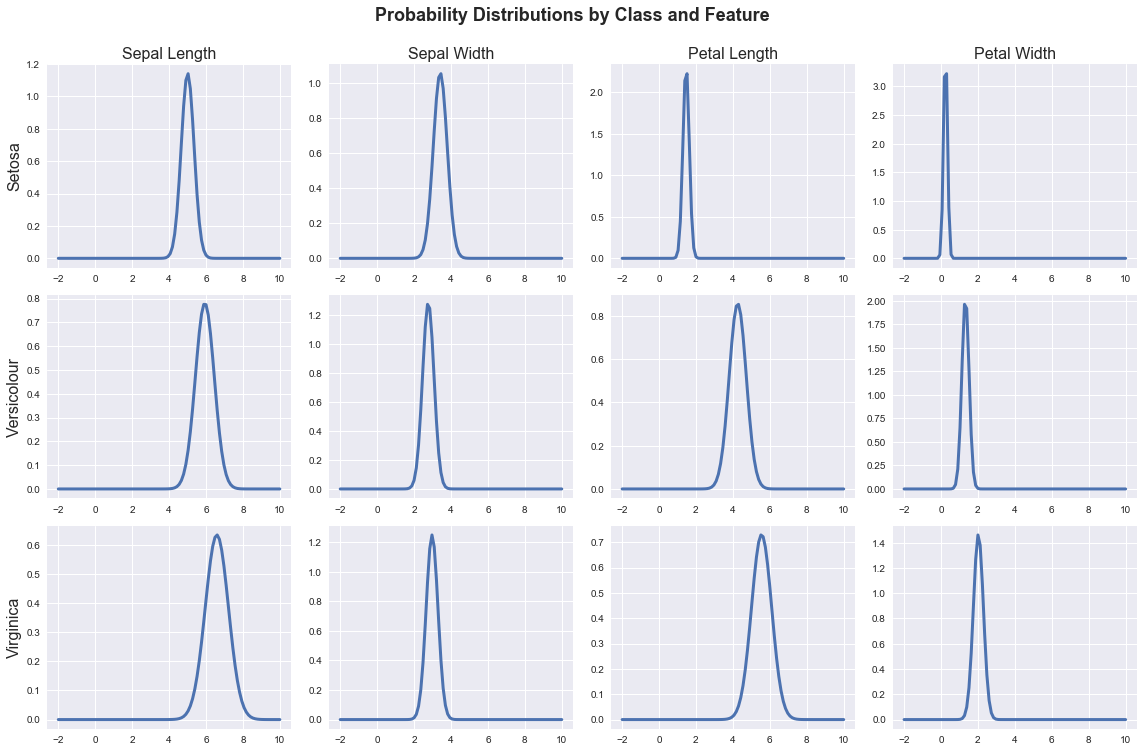

In [12]:
gaus = nb.gaus
means = nb._cond_means
std = nb._cond_std
X = np.linspace(-2,10,100)
fig, ax = plt.subplots(3,4, figsize=(16,10))
for cl in nb._classes:
    for col in range(nb._data_cols):
        ax[cl][col].plot(X,gaus(X,mu=means[cl][col],sig=std[cl][col]), lw=3)
        ax[cl][col].grid(True)
        
cols = ['Sepal Length', 'Sepal Width', 'Petal Length', 'Petal Width']
rows = ['Setosa','Versicolour','Virginica']

fig.suptitle('Probability Distributions by Class and Feature', fontsize=18, fontweight='bold', y=1.04)

for aa, col in zip(ax[0], cols):
    aa.set_title(col, fontsize=16)

for aa, row in zip(ax[:,0], rows):
    aa.set_ylabel(row, rotation=90, fontsize=16)

fig.tight_layout()

## Now Let's try with MNIST

MNIST is a common dataset where numbers are hand written and we're trying to "read" the digit.

In [13]:
from sklearn.datasets import load_digits
digits = load_digits()

X = digits.data
y = digits.target

shuffle = np.random.permutation(range(len(y)))
X = X[shuffle]
y = y[shuffle]
X_train = X[:-100]
y_train = y[:-100]
X_test = X[-100:]
y_test = y[-100:]

Let's split up our data and make sure we have all the different numbers in our training set.

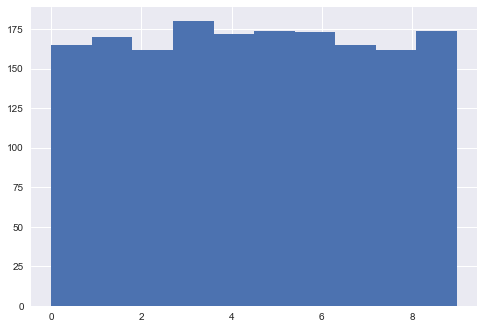

In [14]:
plt.hist(y_train);

Let's take a look at a digit. We see that we're measuring the darkness of each pixel. We'll be treating those as our features, with each pixel getting its own column. We see the first two pixels are empty, and the numerics are 0's. Then we see that we have an "8" and that's a fairly grey pixel, the "12" next to it is much darker. So we'll be building our intution based on "are these pixels normally dark for a 3? Then it's likely to be a 3."

[[  0.   0.   2.  14.  15.   4.   0.   0.]
 [  0.   0.   2.  16.  16.  11.   0.   0.]
 [  0.   0.   2.  16.  16.  10.   0.   0.]
 [  0.   0.   5.  16.  16.   7.   0.   0.]
 [  0.   0.  14.  16.  14.   2.   0.   0.]
 [  0.   4.  16.  16.   8.   0.   0.   0.]
 [  0.   3.  15.  16.   8.   0.   0.   0.]
 [  0.   0.   5.  15.  13.   2.   0.   0.]]


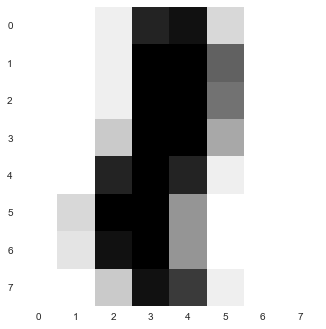

In [15]:
plt.imshow(X[2].reshape(8,8))
print(X[2].reshape(8,8))
plt.grid(False)

In [16]:
nb = gaussian_naive_bayes()
nb.fit(X_train,y_train)

We are 93% accurate on these digits!

In [17]:
nb.score(X_test,y_test)

/Users/zachariahmiller/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:109: RuntimeWarning: divide by zero encountered in log


0.93

/Users/zachariahmiller/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:109: RuntimeWarning: divide by zero encountered in log


Predictions:  [[5], [7], [3], [9], [8], [6], [8], [6]]


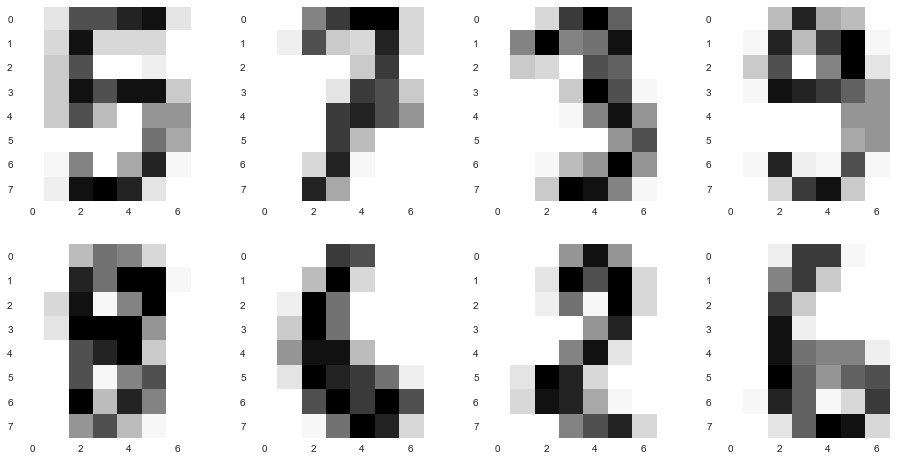

In [22]:
fig, ax = plt.subplots(2,4,figsize=(16,8))
preds = []
np.random.seed(42)
for i,x in enumerate(np.random.choice(range(X.shape[0]),size=8)):
    I = i//4
    J = i%4
    ax[I][J].imshow(X[x].reshape(8,8))
    ax[I][J].grid(False)
    preds.append(nb.predict([X[x]]))
print("Predictions: ",preds)